In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import randint

from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score,classification_report


In [2]:

def read_lines_from_file(file_path):
    
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

    return lines
    
def extract_metadata_from_file(file):

    lines = read_lines_from_file(file)
    
    # remote commented lines and newline characters
    lines_meta = [ x.strip() for x in lines if x[0] not in ['|', '-']][1:]

    lines_meta = [ x for x in lines_meta if x[0] != '']

    # extract the meta data as a dict
    meta_dict = {}

    for idx,this_col in enumerate(lines_meta):
        key_name = this_col.split(':')[0]
        key_vals = this_col.split(':')[1]

        vals_dict = {}
        
        vals_dict['values'] = key_vals.split(',')
        vals_dict['id'] = idx
        
        if 'continuous' in key_vals:
            vals_dict['is_categorical'] = False
        else:
            vals_dict['is_categorical'] = True

        meta_dict[key_name] = vals_dict
    
    return meta_dict



## Import Census Data 

In [62]:
df_test = pd.read_csv('census_income_test.csv',index_col=False,header=None)
df_train = pd.read_csv('census_income_learn.csv',index_col=False,header=None)

# load the metadata file
file_path = 'census_income_metadata.txt'
meta_dict = extract_metadata_from_file(file_path)

# generate a better labeled list for the column names
columns_names = list(meta_dict.keys())
columns_names.append('income bracket')

df_train.columns = columns_names
df_test.columns = columns_names

df_train.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income bracket
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [51]:
np.sum([len(meta_dict[x]['values']) for x in meta_dict.keys()])

503

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, ' Divorced'),
  Text(1, 0, ' Married-A F spouse present'),
  Text(2, 0, ' Married-civilian spouse present'),
  Text(3, 0, ' Married-spouse absent'),
  Text(4, 0, ' Never married'),
  Text(5, 0, ' Separated'),
  Text(6, 0, ' Widowed')])

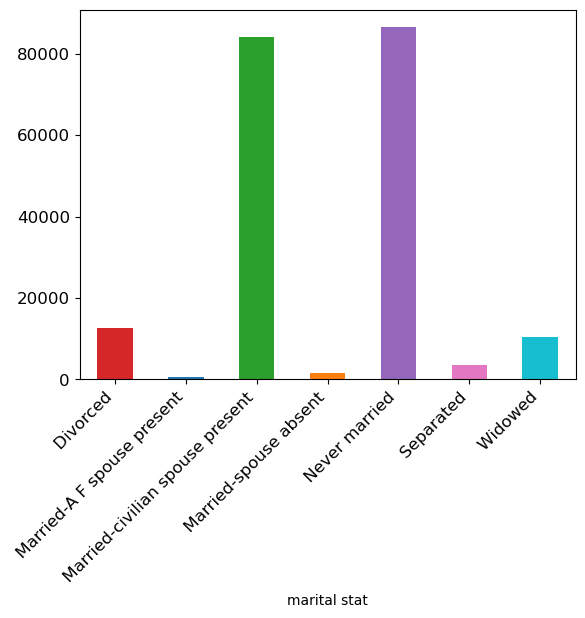

In [24]:
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:pink', 'tab:cyan']
df_train.groupby('marital stat').agg('count')['age'].plot(kind='bar',color=bar_colors,fontsize=12)

plt.xticks(rotation=45,ha='right')

Text(0.5, 0, 'Age')

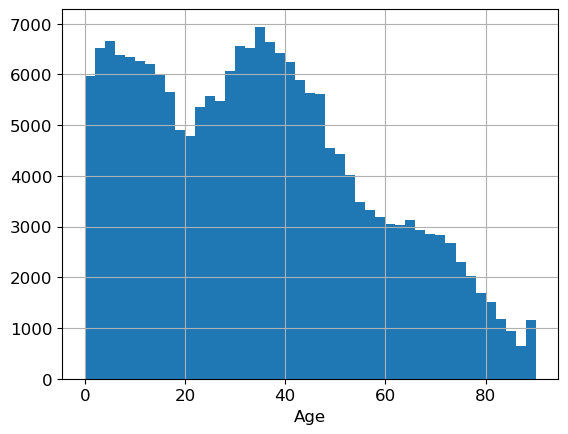

In [28]:
df_train['age'].hist(bins=45,xlabelsize=12, ylabelsize=12)
plt.xlabel('Age',fontsize=12)

In [8]:
columns_names

['age',
 'class of worker',
 'detailed industry recode',
 'detailed occupation recode',
 'education',
 'wage per hour',
 'enroll in edu inst last wk',
 'marital stat',
 'major industry code',
 'major occupation code',
 'race',
 'hispanic origin',
 'sex',
 'member of a labor union',
 'reason for unemployment',
 'full or part time employment stat',
 'capital gains',
 'capital losses',
 'dividends from stocks',
 'tax filer stat',
 'region of previous residence',
 'state of previous residence',
 'detailed household and family stat',
 'detailed household summary in household',
 'instance weight',
 'migration code-change in msa',
 'migration code-change in reg',
 'migration code-move within reg',
 'live in this house 1 year ago',
 'migration prev res in sunbelt',
 'num persons worked for employer',
 'family members under 18',
 'country of birth father',
 'country of birth mother',
 'country of birth self',
 'citizenship',
 'own business or self employed',
 "fill inc questionnaire for veteran

## Class Imbalance in Target

Text(0.5, 0, ' ')

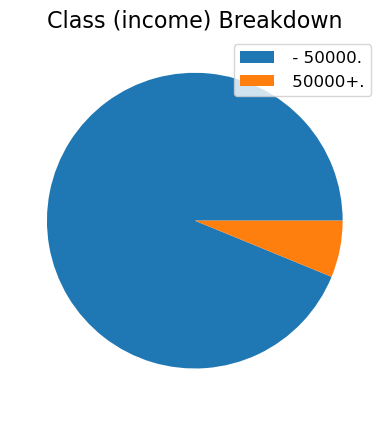

In [44]:
df_train['income bracket'].value_counts().plot.pie(label=None)

plt.title('Class (income) Breakdown', fontsize=16)
plt.legend(df_train['income bracket'].value_counts().index,fontsize=12)
plt.ylabel('', fontsize=16)
plt.xlabel(' ', fontsize=16)

In [53]:
# Percent of Target for < $50,000 
class_counts = df_train['income bracket'].value_counts() 
class_counts[' - 50000.']/(class_counts[' 50000+.']+class_counts[' - 50000.'])*100

93.79419916500854

In [54]:
class_counts

income bracket
- 50000.    187141
50000+.      12382
Name: count, dtype: int64

## Model Training - Unbalanced Data

In [57]:
# get all categorical columns from the me adata
cat_columns = [meta_dict[x]['id'] for x in meta_dict.keys() if meta_dict[x]['is_categorical']]
numer_columns = [meta_dict[x]['id'] for x in meta_dict.keys() if not meta_dict[x]['is_categorical']]


In [60]:

# # Initialize CatBoostRegressor
model = CatBoostClassifier(iterations=5,
                           learning_rate=1,
                           cat_features=cat_columns,
                           max_depth=8)

# # Fit model
model.fit(df_train[df_train.columns[:41]], df_train[df_train.columns[41]])


0:	learn: 0.1530219	total: 166ms	remaining: 664ms
1:	learn: 0.1333924	total: 262ms	remaining: 393ms
2:	learn: 0.1249532	total: 356ms	remaining: 238ms
3:	learn: 0.1225991	total: 461ms	remaining: 115ms
4:	learn: 0.1198147	total: 541ms	remaining: 0us


### Model Evaluation

In [63]:
# Extract Evaluation (test) data
eval_data = df_test[df_test.columns[:41]]
y_true = df_test[df_test.columns[41]]

# Generate predictions on the test data
y_test = model.predict(eval_data)

# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)

# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')


In [64]:
accuracy = accuracy_score(y_true, y_test)
print(f"Accuracy: {accuracy}")
print(' ')
print(classification_report(y_true, y_test))

Accuracy: 0.9541709268057978
 
              precision    recall  f1-score   support

    - 50000.       0.96      0.99      0.98     93576
     50000+.       0.71      0.44      0.55      6186

    accuracy                           0.95     99762
   macro avg       0.84      0.72      0.76     99762
weighted avg       0.95      0.95      0.95     99762



### Feature Importance

In [198]:
feat_importance = model.get_feature_importance()
preds_class = model.score(df_test[df_test.columns[:41]],df_test[41])

preds_class

0.9541709268057978

Text(0.5, 0, 'Feature Importance')

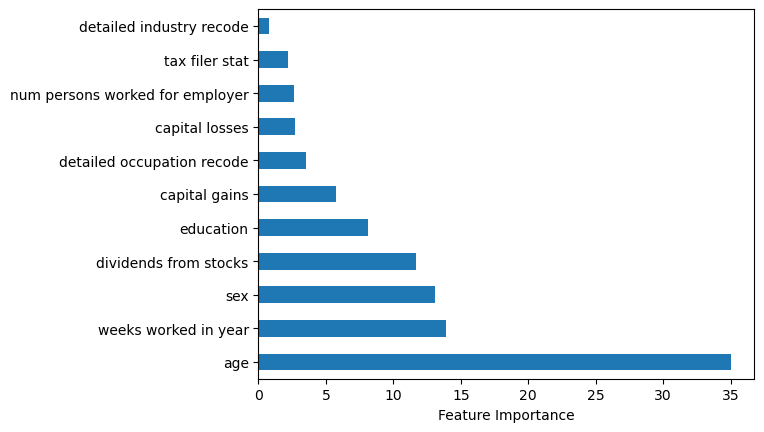

In [65]:
(pd.Series(model.get_feature_importance(), index=meta_dict.keys())
   .nlargest(11)
   .plot(kind='barh'))   
plt.xlabel('Feature Importance')

## Hyperparameter Tuning

In [127]:
# Creating the hyperparameter grid
param_dist = { "learning_rate":np.linspace(0,0.2,5),
               "max_depth": randint(3, 10)}

# # Initialize CatBoostRegressor
cat_model = CatBoostClassifier(iterations=5,
                           learning_rate=1,
                           cat_features=cat_columns)


#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cat_model , param_dist, scoring='accuracy', cv=None)

cat_out = rscv.fit(df[df.columns[:41]], df[41])

In [99]:
#cat_out = rscv.fit(df[df.columns[:41]], df[41])

0:	learn: 0.3680235	total: 76.8ms	remaining: 307ms
1:	learn: 0.2498993	total: 156ms	remaining: 233ms
2:	learn: 0.1989132	total: 227ms	remaining: 151ms
3:	learn: 0.1747121	total: 294ms	remaining: 73.4ms
4:	learn: 0.1563971	total: 359ms	remaining: 0us
0:	learn: 0.3680193	total: 71.5ms	remaining: 286ms
1:	learn: 0.2492087	total: 144ms	remaining: 216ms
2:	learn: 0.1979427	total: 209ms	remaining: 140ms
3:	learn: 0.1737143	total: 272ms	remaining: 67.9ms
4:	learn: 0.1562150	total: 335ms	remaining: 0us
0:	learn: 0.3804033	total: 71ms	remaining: 284ms
1:	learn: 0.2523246	total: 140ms	remaining: 210ms
2:	learn: 0.1972035	total: 213ms	remaining: 142ms
3:	learn: 0.1729449	total: 277ms	remaining: 69.1ms
4:	learn: 0.1549336	total: 348ms	remaining: 0us
0:	learn: 0.3890368	total: 70.7ms	remaining: 283ms
1:	learn: 0.2483331	total: 152ms	remaining: 228ms
2:	learn: 0.1957175	total: 221ms	remaining: 148ms
3:	learn: 0.1707714	total: 283ms	remaining: 70.8ms
4:	learn: 0.1550574	total: 345ms	remaining: 0us
0:

/Users/degi/opt/anaconda3/envs/geospatial/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/degi/opt/anaconda3/envs/geospatial/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/degi/opt/anaconda3/envs/geospatial/lib/python3.12/site-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_

0:	learn: 0.3906216	total: 91.6ms	remaining: 366ms
1:	learn: 0.2532029	total: 206ms	remaining: 310ms
2:	learn: 0.1985186	total: 297ms	remaining: 198ms
3:	learn: 0.1717634	total: 387ms	remaining: 96.9ms
4:	learn: 0.1536713	total: 460ms	remaining: 0us


RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x31abe38c0>,
                   param_distributions={'learning_rate': array([0.  , 0.05, 0.1 , 0.15, 0.2 ]),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x31abe33e0>},
                   scoring='accuracy')

In [122]:
rscv.best_params_

{'learning_rate': 0.2, 'max_depth': 8}

In [134]:
# df_save = df.sample(50000)

# columns_names = list(meta_dict.keys())
# columns_names.append('income bracket')

# df.columns = columns_names

# df_save.to_csv('sample.csv',index=False)

### Let's try to keep our classes balanced


In [66]:
df_train_all_cat = df_train.copy()

In [67]:
df_train_all_cat.head(2)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income bracket
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.


### Convert numericals to binned categoricals

In [87]:
## TRAINING DATA

df_train_all_cat = df_train.copy()

# Define the bin edges (the boundaries of your brackets). These were defined from some quick quantile analysis
age_bins = [-0.001, 20, 40, 60, 80, 120]  
cap_gains_bins = [-0.001, 0.001, 2500, 5000, 1000000]
cap_loss_bins = [-0.001, 0.001, 1000, 500000]
dividens_bins = [-0.001, 0.001, 1000, 500000]
weeks_worked_bins = [-0.001,0.001,51.999,52]

# Apply the cut() function to bin the 'age' column
df_train_all_cat['age'] = pd.cut(df_train_all_cat['age'], age_bins,right=True).astype('str')
df_train_all_cat['capital gains'] = pd.cut(df_train_all_cat['capital gains'], cap_gains_bins).astype('str')
df_train_all_cat['capital losses'] = pd.cut(df_train_all_cat['capital losses'], cap_loss_bins).astype('str')
df_train_all_cat['dividends from stocks'] = pd.cut(df_train_all_cat['dividends from stocks'], dividens_bins).astype('str')
df_train_all_cat['weeks worked in year'] = pd.cut(df_train_all_cat['weeks worked in year'], weeks_worked_bins).astype('str')


## TEST DATA

df_test_all_cat = df_test.copy()

# Apply the cut() function to bin the 'age' column
df_test_all_cat['age'] = pd.cut(df_test_all_cat['age'], age_bins,right=True).astype('str')
df_test_all_cat['capital gains'] = pd.cut(df_test_all_cat['capital gains'], cap_gains_bins).astype('str')
df_test_all_cat['capital losses'] = pd.cut(df_test_all_cat['capital losses'], cap_loss_bins).astype('str')
df_test_all_cat['dividends from stocks'] = pd.cut(df_test_all_cat['dividends from stocks'], dividens_bins).astype('str')
df_test_all_cat['weeks worked in year'] = pd.cut(df_test_all_cat['weeks worked in year'], weeks_worked_bins).astype('str')


Text(0.5, 0, 'Age Brackets')

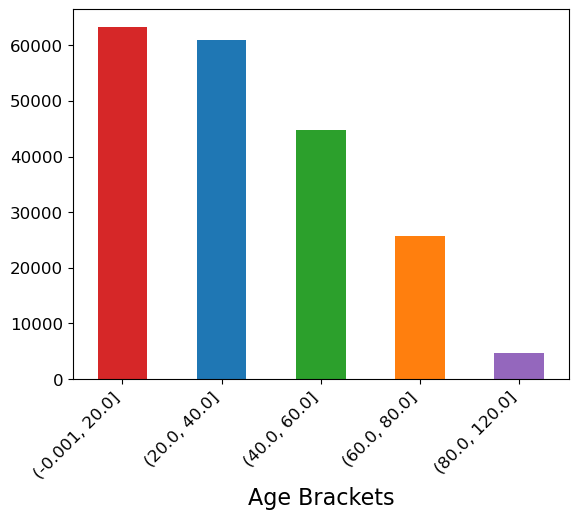

In [80]:
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:pink', 'tab:cyan']
df_train_all_cat.groupby('age').agg('count')['capital gains'].plot(kind='bar',color=bar_colors,fontsize=12)

plt.xticks(rotation=45,ha='right')
plt.xlabel('Age Brackets',fontsize=16)

In [101]:
# Features of interest derived from analysis of prior trained model

features_of_interest = ['capital gains', 'capital losses', 'dividends from stocks', 'weeks worked in year', 
'age','sex','education','detailed occupation recode','num persons worked for employer',
'tax filer stat', 'detailed industry recode','income bracket']


In [70]:
len(df_train_all_cat[features_of_interest])

199523

In [90]:
dedupped_df_train = df_train_all_cat[features_of_interest].drop_duplicates()
FOI_df_test = df_test_all_cat[features_of_interest]

In [72]:
# Percent of Target for < $50,000 
class_counts = dedupped_df_train['income bracket'].value_counts()
class_counts[' - 50000.']/(class_counts[' 50000+.']+class_counts[' - 50000.'])*100

85.58349179519684

In [ ]:
# Randomly sample 20% of the rows 
rows_to_drop_indices = dedupped_df_train[dedupped_df_train['income bracket'] == ' - 50000.'].sample(frac=0.8, random_state=42).index

# Drop the randomly selected rows from the original dataframe
dedupped_df_train_cleaned = dedupped_df_train.drop(rows_to_drop_indices)

In [74]:
# Percent of Target for < $50,000 
class_counts = dedupped_df_train_cleaned['income bracket'].value_counts() 
class_counts[' - 50000.']/(class_counts[' 50000+.']+class_counts[' - 50000.'])*100

54.281502657792466

In [75]:
class_counts

income bracket
- 50000.    12152
50000+.     10235
Name: count, dtype: int64

## Re-Train Model

In [84]:
# get all categorical columns for the cleaned data (i.e. all columns, not target)
cat_clean_cols = list(range(len(dedupped_df_train_cleaned.columns[:-1])))

# # Initialize CatBoostRegressor
model = CatBoostClassifier(iterations=5,
                           learning_rate=1,
                           cat_features=cat_clean_cols,
                           max_depth=4)

# # # Fit model
model.fit(dedupped_df_train_cleaned[dedupped_df_train_cleaned.columns[:-1]], 
          dedupped_df_train_cleaned[dedupped_df_train_cleaned.columns[-1]])


0:	learn: 0.5433143	total: 5.35ms	remaining: 21.4ms
1:	learn: 0.4972923	total: 9.84ms	remaining: 14.8ms
2:	learn: 0.4637988	total: 12.7ms	remaining: 8.45ms
3:	learn: 0.4571371	total: 15.7ms	remaining: 3.93ms
4:	learn: 0.4512248	total: 18.9ms	remaining: 0us


### Model Evaluation

In [91]:
# Extract Evaluation (test) data
eval_data = dedupped_df_train[FOI_df_test.columns[:-1]]
y_true = dedupped_df_train[FOI_df_test.columns[-1]]

# Generate predictions on the test data
y_test = model.predict(eval_data)

# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)

# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')


In [92]:
accuracy = accuracy_score(y_true, y_test)
print(f"Accuracy: {accuracy}")
print(' ')
print(classification_report(y_true, y_test))

Accuracy: 0.80376082822734
 
              precision    recall  f1-score   support

    - 50000.       0.95      0.81      0.88     60760
     50000+.       0.40      0.77      0.53     10235

    accuracy                           0.80     70995
   macro avg       0.68      0.79      0.70     70995
weighted avg       0.87      0.80      0.83     70995



### Feature Importance

In [93]:
feat_importance = model.get_feature_importance()
# preds_class = model.score(df_test[df_test.columns[:41]],df_test[41])

# preds_class

Text(0.5, 0, 'Income Bracket')

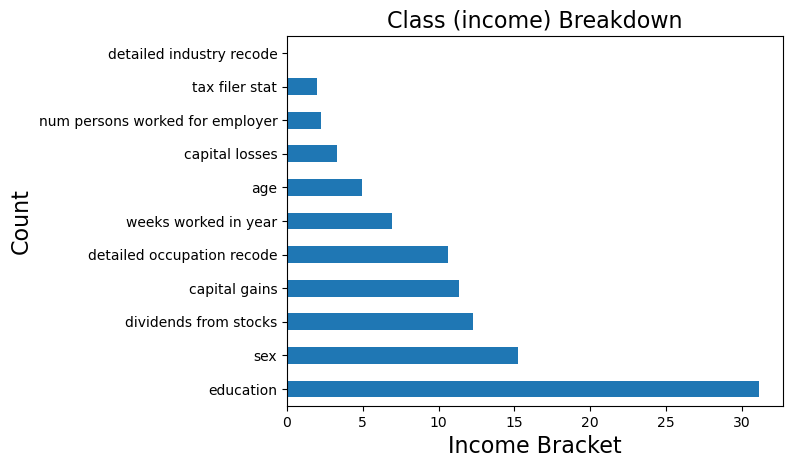

In [94]:
(pd.Series(model.get_feature_importance(), index=dedupped_df_train.columns[:-1])
   .nlargest(11)
   .plot(kind='barh'))   
plt.xlabel('Feature Importance')
plt.title('Class (income) Breakdown', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Income Bracket', fontsize=16)

### Hyperparameter Tuning

In [390]:
# Creating the hyperparameter grid
param_dist = { "learning_rate":np.linspace(0,0.2,5),
               "max_depth": randint(1,5)}

# # Initialize CatBoostRegressor
cat_model = CatBoostClassifier(iterations=5,
                           learning_rate=1,
                           cat_features=cat_clean_cols)


#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cat_model , param_dist, scoring='accuracy', cv=None)



cat_out = rscv.fit(dedupped_df_train_cleaned[dedupped_df_train_cleaned.columns[:-1]], 
          dedupped_df_train_cleaned[dedupped_df_train_cleaned.columns[-1]])

0:	learn: 0.6644348	total: 8.05ms	remaining: 32.2ms
1:	learn: 0.6459028	total: 10.4ms	remaining: 15.5ms
2:	learn: 0.6328418	total: 11.7ms	remaining: 7.77ms
3:	learn: 0.6105177	total: 12.7ms	remaining: 3.18ms
4:	learn: 0.5947911	total: 14ms	remaining: 0us
0:	learn: 0.6637703	total: 1.66ms	remaining: 6.63ms
1:	learn: 0.6448933	total: 3.12ms	remaining: 4.69ms
2:	learn: 0.6310575	total: 4.6ms	remaining: 3.06ms
3:	learn: 0.6177605	total: 5.56ms	remaining: 1.39ms
4:	learn: 0.5973633	total: 6.57ms	remaining: 0us
0:	learn: 0.6645051	total: 1.55ms	remaining: 6.2ms
1:	learn: 0.6461009	total: 2.78ms	remaining: 4.16ms
2:	learn: 0.6325100	total: 3.76ms	remaining: 2.51ms
3:	learn: 0.6187988	total: 4.65ms	remaining: 1.16ms
4:	learn: 0.5989012	total: 5.67ms	remaining: 0us
0:	learn: 0.6636572	total: 1.34ms	remaining: 5.37ms
1:	learn: 0.6446010	total: 2.5ms	remaining: 3.75ms
2:	learn: 0.6302173	total: 3.48ms	remaining: 2.32ms
3:	learn: 0.6165179	total: 4.39ms	remaining: 1.1ms
4:	learn: 0.5960969	total: 

In [393]:
cat_out.best_estimator_

In [394]:
# Extract Evaluation (test) data
eval_data = dedupped_df_train[dedupped_df_train.columns[:-1]]
y_true = dedupped_df_train[dedupped_df_train.columns[-1]]

# Generate predictions on the test data
y_test = cat_out.best_estimator_.predict(eval_data)

# Get predicted probabilities for each class
preds_proba = cat_out.best_estimator_.predict_proba(eval_data)

# Get predicted RawFormulaVal
preds_raw = cat_out.best_estimator_.predict(eval_data, prediction_type='RawFormulaVal')


In [102]:
accuracy = accuracy_score(y_true, y_test)
print(f"Accuracy: {accuracy}")
print(' ')
print(classification_report(y_true, y_test))

Accuracy: 0.80376082822734
 
              precision    recall  f1-score   support

    - 50000.       0.95      0.81      0.88     60760
     50000+.       0.40      0.77      0.53     10235

    accuracy                           0.80     70995
   macro avg       0.68      0.79      0.70     70995
weighted avg       0.87      0.80      0.83     70995



### Inspect the Age Brackets

In [97]:
dedupped_df_train_cleaned['income bracket'].unique()

array([' - 50000.', ' 50000+.'], dtype=object)

Text(0.5, 0, 'Age Brackets')

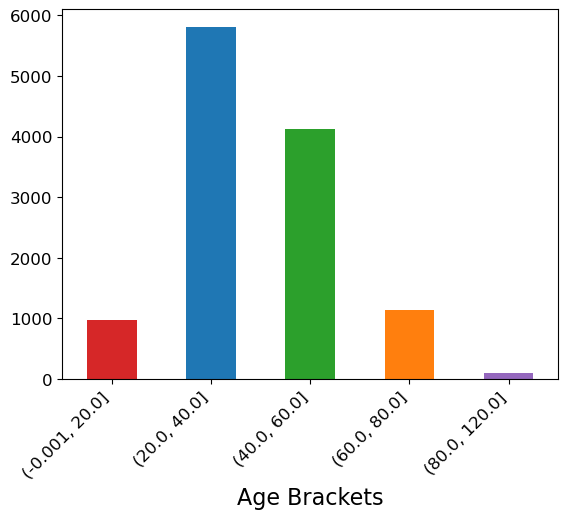

In [98]:
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:pink', 'tab:cyan']
dedupped_df_train_cleaned[dedupped_df_train_cleaned['income bracket'] == ' - 50000.'].groupby('age').agg('count')['capital gains'].plot(kind='bar',color=bar_colors,fontsize=12)

plt.xticks(rotation=45,ha='right')
plt.xlabel('Age Brackets',fontsize=16)

Text(0.5, 0, 'Age Brackets')

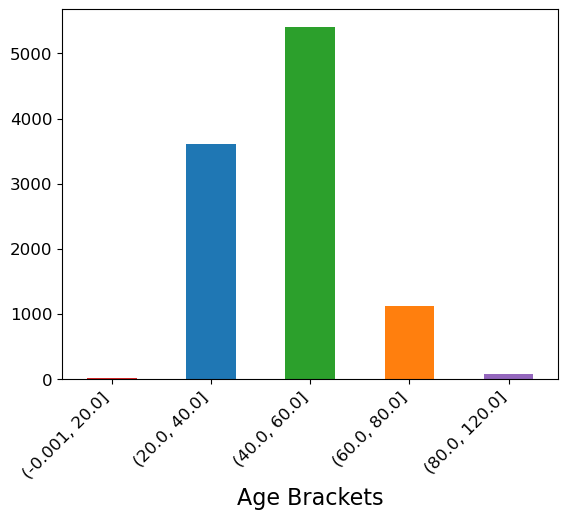

In [100]:
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:pink', 'tab:cyan']
dedupped_df_train_cleaned[dedupped_df_train_cleaned['income bracket'] == ' 50000+.'].groupby('age').agg('count')['capital gains'].plot(kind='bar',color=bar_colors,fontsize=12)

plt.xticks(rotation=45,ha='right')
plt.xlabel('Age Brackets',fontsize=16)